In [1]:
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# LOADING DATA

load both datasets and tokenize them then we return the raw text/a dataframe having every tweet as a row/vocabullary generated by tokenizing this dataset

In [2]:
# a method that reads a file and removes all non-ascii characters from it 
# returns raw_text,list [tweets]
def loadFile(filename):
       
    f = open(filename)
    raw_tweets = f.read()
    remove_nonunicode = re.sub(r'[^\x00-\x7F]',' ', raw_tweets)
    content = remove_nonunicode.splitlines()
    return remove_nonunicode,content

In [3]:
def tokenize_tweets(raw_data,op):

    tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = tknzr.tokenize(raw_data)
    words = [w.lower() for w in tokens]
    if op == "vocab":
        vocab = set(words)
    elif op == "raw":
        vocab = words
    return vocab

In [4]:
def loadData(pos_file,neg_file,op):
    
    #dataframe
    positive_raw,positive_tweets = loadFile(pos_file)
    negative_raw,negative_tweets = loadFile(neg_file)
    positive_labels = np.zeros((len(positive_tweets),),dtype=int)
    negative_labels = np.ones((len(negative_tweets),),dtype=int)
    combined_tweets = positive_tweets + negative_tweets
    combined_labels = np.append(positive_labels,negative_labels)
    # vocabullary 
    positive_vocab =  tokenize_tweets(positive_raw,op)
    negative_vocab =  tokenize_tweets(negative_raw,op)
    if op == "raw":
        combined_vocab =  positive_vocab + negative_vocab
    elif op == "vocab":
        combined_vocab =  list(positive_vocab.union(negative_vocab))
    # raw text
    combined_text = positive_raw + negative_raw
    return combined_tweets,combined_labels,combined_vocab,combined_text

# LOGISTIC REGRESSION
An abstraction used by later methods , splits the data and trains the model and provides accuracy scores

In [5]:
def shuffle_data(x, y):
    
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    tempX = x
    tempY = y
    tempX=tempX[indices]
    tempY=tempY[indices]
    return tempX,tempY

In [6]:
def train_by_logistic(tweets_df,vocab,labels):
    
    cv = CountVectorizer(vocabulary=vocab)
    occurence = cv.fit_transform(tweets_df)
        
    X_train, X_test, y_train, y_test = train_test_split(occurence,labels,test_size=0.2,random_state=0)
    logistic = LogisticRegression(C=1e5)
    model = logistic.fit(X_train,y_train)
    Y_pred = model.predict(X_test)
    accuracy = accuracy_score( y_test,Y_pred)
    
    return  accuracy

# Threshold

Eliminating words having lower number of occurrences than a certain threshold and use that set as the vocabullary , then we run logistic regression to compare the different sets of vocabullary

In [7]:
def findMinThreshold(tweets,tweets_df,vocab,labels):
    
    tokens = tokenize_tweets(tweets,"raw")
    fdist = nltk.FreqDist(tokens)
    token_frequency_pairs = fdist.most_common(len(fdist.keys()))
    acc_scores = []
    train_words = []
    shuffle_tweets,shuffle_labels = shuffle_data(tweets_df,labels)
    for min_freq in range(0,60,5):
        non_uniqe_vocab = list(map(lambda pair: pair[0] ,list(filter(lambda token : token[1]>min_freq,token_frequency_pairs))))
        unique_vocuballry = np.unique(non_uniqe_vocab)
        accuracy = train_by_logistic(shuffle_tweets,unique_vocuballry,shuffle_labels)
        acc_scores.append(accuracy)
        train_words.append(min_freq)
      
    
    return acc_scores,train_words

# REDUNDANCY

Here we combine the vocabullary of both datasets and we consider the words that are common between both texts and we start to eliminate these common vocabullary and train by logistic as before

In [14]:
def findCommonTokens(raw_pos,raw_neg):
   
    all_text = tokenize_tweets(raw_pos + raw_neg,"raw")
    common_vocab = (tokenize_tweets(raw_pos,"vocab")).intersection(tokenize_tweets(raw_neg,"vocab"))
    freq_total = nltk.FreqDist(all_text)
    tokens_total = freq_total.most_common(len(freq_total.keys()))
    filtered_tokens = list(filter(lambda x: x[0] in common_vocab,tokens_total))
    return filtered_tokens

In [23]:
def eliminateRedundancy(tokens,tweets_df,combined_vocab,labels):
    
    acc_scores = []
    train_words = []
    shuffle_tweets,shuffle_labels = shuffle_data(tweets_df,labels)
    for elem_rate in range(5,30,5):
        
       
        removal_index = int((elem_rate/100) * len(tokens))
        most_frequent =  set(map(lambda x : x[0],tokens[0:removal_index]))
        filtered_vocab = list(filter(lambda word: word not in most_frequent,combined_vocab))
        
        accuracy = train_by_logistic(shuffle_tweets,filtered_vocab,shuffle_labels)
        acc_scores.append(accuracy)
        train_words.append(elem_rate)  
    
    return acc_scores,train_words
    

# VISUALIZING RESULTS

In [10]:
def visualizeCommonTokens(tokens):
    
    most_frequent = tokens[0:31]
    words = list(map(lambda x: x[0],most_frequent))
    frequency = list(map(lambda x: x[1],most_frequent))
    x_pos = np.arange(len(most_frequent)) 

    plt.figure(figsize=(20, 3))   
    plt.bar(x_pos,frequency,align='center')
    plt.xticks(x_pos,words) 
    plt.ylabel('Frequency')
    plt.title('Frequency of the 30 most common words in both datasets')
    plt.show()    

In [11]:
def visualizeAccuracy(acc_scores,train_words,xtitle,ytitle,graphTitle):
    
    plt.scatter(train_words,acc_scores)
    plt.plot(train_words,acc_scores)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.title(graphTitle)
    plt.show()
    

# RUN SCRIPT

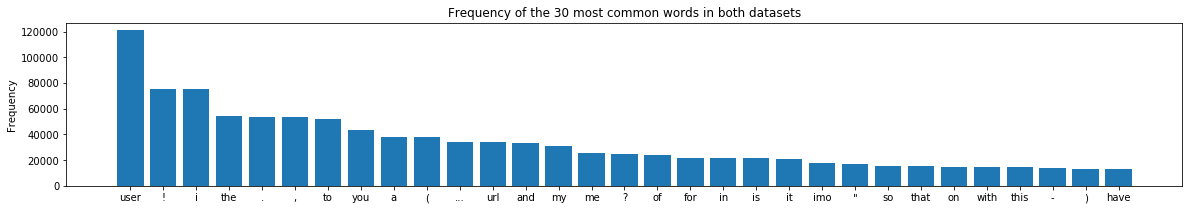

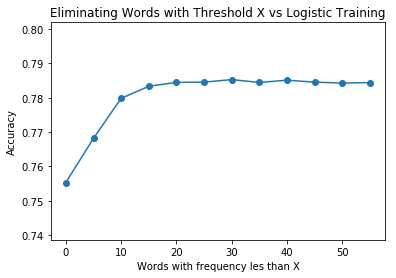

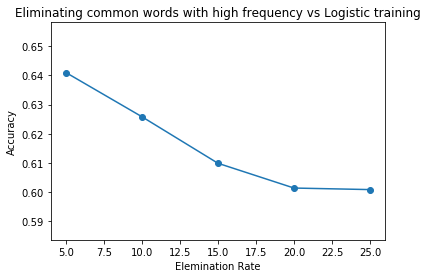

In [25]:
def combineDataSets():

    tweets_pos = '../tmp/clean_train_pos.txt'
    tweets_neg = '../tmp/clean_train_neg.txt' 
    combined_tweets,combined_labels,combined_vocab,combined_text = loadData(tweets_pos,tweets_neg,"vocab")
    combined_tweets = np.array(combined_tweets)

    raw_text_pos,_ =  loadFile(tweets_pos)
    raw_text_neg,_ =  loadFile(tweets_neg)
    tokens = findCommonTokens(raw_text_pos,raw_text_neg)
    visualizeCommonTokens(tokens)
    acc_scores1,train_words1 = findMinThreshold(combined_text,combined_tweets,combined_vocab,combined_labels)
    visualizeAccuracy(acc_scores1,train_words1,'Words with frequency les than X','Accuracy','Eliminating Words with Threshold X vs Logistic Training')
    acc_scores2,train_words2 = eliminateRedundancy(tokens,combined_tweets,combined_vocab,combined_labels)
    visualizeAccuracy(acc_scores2,train_words2,'Elemination Rate','Accuracy','Eliminating common words with high frequency vs Logistic training')   
combineDataSets()    

# VISUALIZING DATA

In [12]:
from wordcloud import WordCloud
def generateWordClouds(raw_text):

    wordcloud = WordCloud().generate(raw_text)
    wordcloud = WordCloud(max_font_size=40).generate(raw_text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

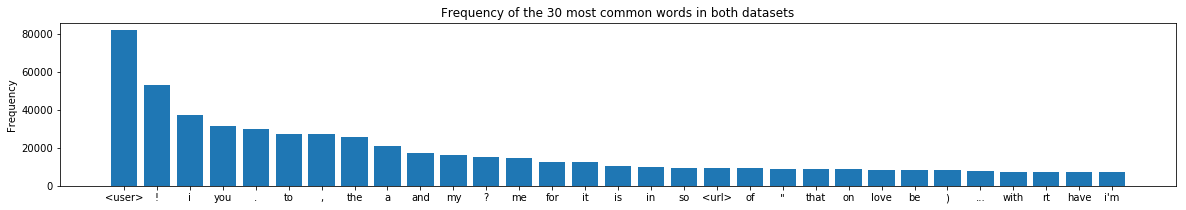

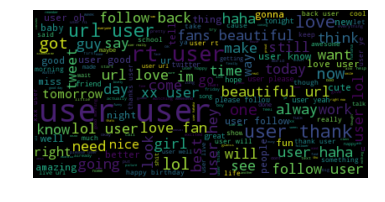

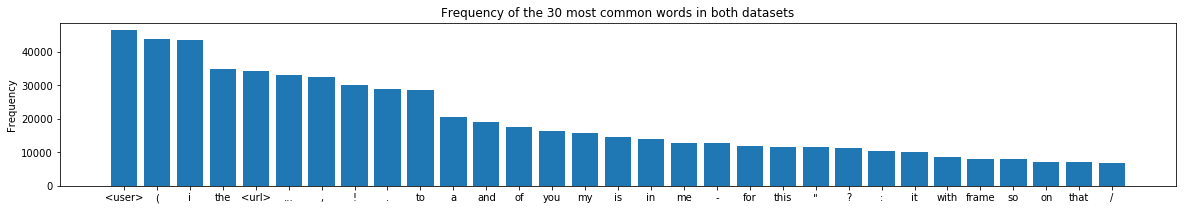

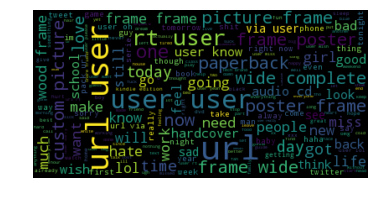

In [17]:
def visualize_tweets_seperatley():
    raw_pos,_,_ = loadData('../data/train_pos.txt')
    raw_neg,_,_ = loadData('../data/train_neg.txt')
    pos_tokens_freq = nltk.FreqDist(tokenize_tweets(raw_pos,"raw"))
    neg_tokens_freq = nltk.FreqDist(tokenize_tweets(raw_neg,"raw"))
    visualizeCommonTokens(pos_tokens_freq.most_common(len(pos_tokens_freq.keys())))
    generateWordClouds(raw_pos)
    visualizeCommonTokens(neg_tokens_freq.most_common(len(neg_tokens_freq.keys())))
    generateWordClouds(raw_neg)

visualize_tweets_seperatley()    

# CLEAN TWEETS GENERATION

In [26]:
def generate(pos_file,neg_file):
    
    tweets_pos = '../tmp/clean_train_pos.txt'
    tweets_neg = '../tmp/clean_train_neg.txt' 
    combined_tweets,combined_labels,combined_vocab,combined_text = loadData(tweets_pos,tweets_neg,"vocab")
    
    tokens = tokenize_tweets(combined_text,"raw")
    fdist = nltk.FreqDist(tokens)
    token_frequency_pairs = fdist.most_common(len(fdist.keys()))
    
    non_uniqe_vocab = list(map(lambda pair: pair[0] ,list(filter(lambda token : token[1]>25,token_frequency_pairs))))
    unique_vocuballry = np.unique(non_uniqe_vocab)
   
    writeToFile(unique_vocuballry,'../tmp/vocab.txt')

In [27]:
def writeToFile(data,outputSet):
    result = open(outputSet, 'w')
    if (type(data) is np.ndarray or type(data) is list):
        for item in data:
            result.write("%s\n" % item)
        result.close()

In [28]:
generate('../tmp/clean_train_pos.txt','../tmp/clean_train_neg.txt')